In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import glob

import gc
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import imgaug.augmenters as iaa
import tensorflow as tf
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from skimage.segmentation import slic
from keras import backend as K

color = sns.color_palette()
%matplotlib inline




['chest_xray', '__MACOSX']


Using TensorFlow backend.


In [0]:
data_dir = Path("data/chest_xray/chest_xray")
train_dir= data_dir/'train'
val_dir=data_dir/'val'
test_dir = data_dir / 'test'


A basic function to load train images from the directory and save it in a dataframe with labels.

In [0]:
def load_train():
    normal_cases_dir = train_dir / 'NORMAL'
    pneumonia_cases_dir = train_dir / 'PNEUMONIA'

    # Get the list of all the images
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
    train_data=[]
    train_label=[]
    for img in normal_cases:
            train_data.append(img)
            train_label.append(0)
    for img in pneumonia_cases:
        train_data.append(img)
        train_label.append(1)
    df=pd.DataFrame(train_data)
    df.columns=['images']
    df['labels']=train_label
    df=df.sample(frac=1).reset_index(drop=True)
    return df

In [0]:
train_data=load_train()
len(train_data)

5216

### Loading and preprocessing validation and test data
Steps:-
* Load the image using imread()
* Since the images are of different length and widths, resize them to 224,224.
* Some images in our data are greyscale (1 channel) , therefore convert them to 3 channel
* Images using cv2 are read in BGR format(by default) , convert it to RGB.
* Normalize the image pixels by dividing by 255.

In [0]:
def prepare_and_load(isval=True):
    if isval==True:
        normal_dir=val_dir/'NORMAL'
        pneumonia_dir=val_dir/'PNEUMONIA'
    else:
        normal_dir=test_dir/'NORMAL'
        pneumonia_dir=test_dir/'PNEUMONIA'
    normal_cases = normal_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_dir.glob('*.jpeg')
    data,labels=([] for x in range(2))
    def prepare(case):
        for img in case:
            img = cv2.imread(str(img))
            img = cv2.resize(img, (224,224))
            if img.shape[2] ==1:
                 img = np.dstack([img, img, img])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            if case==normal_cases:
                label = to_categorical(0, num_classes=2)
            else:
                label = to_categorical(1, num_classes=2)
            data.append(img)
            labels.append(label)
        return data,labels
    prepare(normal_cases)
    d,l=prepare(pneumonia_cases)
    d=np.array(d)
    l=np.array(l)
    return d,l
        

In [0]:
val_data,val_labels=prepare_and_load(isval=True)
test_data,test_labels=prepare_and_load(isval=False)

### Generating batches of images for training
* It involves the same preprocessing steps as above, except that images are processed and returned in batches,defined by the batch size.
* We also use Image segmentation ( the slic function of skimage).Image segmentation is the process of partitioning a  image into multiple segments (sets of pixels, also known as super-pixels). The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.
* The dataset we have is Imbalanced and has pneumonia cases three times the normal cases.The goal of our model is to optimize accuracy while training , which it can easily do by classifying most of the cases as infected(since the majority cases are infected, the model will have high accuracy), but it is biased aginst the underrepresented class.Thus we try to augment images of the normal class , by adding flipped , rotated and changing brightness of the original images.

In [0]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            #segmentation
            oig_img=slic(orig_img) 
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            #augmentation
            seq = iaa.OneOf([
                 iaa.Fliplr(), # horizontal flips
                 iaa.Affine(rotate=20), # roatation
                 iaa.Multiply((1.2, 1.5))]) #random brightness
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

# Fine Tuned Model
To train a neural network from scratch,we need a lot of data also lot of processing power and time , which is obviously unavailble and impractical. Therefore, we fine-tune pretrained neural networks. There are a lot of neural networks pretrained on billions of images, that can be used by changing the top layer as per our data.But we use a better technique than that called fine-tuning in which we tweak the parameters of an already trained network so that it adapts to the new task at hand. 

The initial layers learn very general features and as we go higher up the network, the layers tend to learn patterns more specific to the task it is being trained on. Thus, for fine-tuning, we want to keep the initial layers intact ( or freeze them ) and retrain the later layers for our task.

I have used the VGG16 model and added my own dense layers at the bottom, then I freeze the network upto the second last convolutional block, after which I retrain.

![](https://i.imgur.com/Jjh8f0z.png)

In [0]:
def vgg16_model( num_classes=None):

    model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

    x=Dense(1024, activation='relu')(model.layers[-4].output)# add my own dense layer after the last conv block
    x=Dropout(0.7)(x)
    x=Dense(512,activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(2,activation='softmax')(x)
    model=Model(model.input,x)
    
    return model


In [0]:
vgg_conv=vgg16_model(2)
for layer in vgg_conv.layers[:-10]:#freeze all layers except the last ten
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 6s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
<keras.engine.input_layer.InputLayer object at 0x7f6cf00614a8> False
<keras.layers.convolutional.Conv2D object at 0x7f6cf0061358> False
<keras.layers.convolutional.Conv2D object at 0x7f6cf00615f8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f6cf01ba1d0> False
<keras.layers.convolutional.Conv2D object at 0x7f6cf01ba940> False
<keras.layers.convolutional.Conv2D object at 0x7f6cf00fe278> False
<keras.layers.pooling.MaxPooling2D object at 0x7f6cf00a0d68> False
<keras.layers.convolutional.Conv2D object at 0x7f6cf00a0a20> False
<keras.layers.convolutional.Conv2D object at 0x7f6cd43ec898> False
<keras.layers.convolutional.Conv2D object at 0x7f6cd440a9b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f6cd43bc8d0> False
<keras.

In [0]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
opt = Adam(lr=0.0001, decay=1e-5)
early_stop = EarlyStopping(monitor='loss',patience=3,verbose=1)
vgg_conv.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [0]:
batch_size = 16
nb_epochs = 5

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(val_data)))

Number of training and validation steps: 326 and 16


In [0]:
# # Fit the model
history = vgg_conv.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(val_data,val_labels),callbacks=[early_stop],
                               class_weight={0:1.0, 1:0.4})

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
326/326 [==============================] - 312s 958ms/step - loss: 0.1343 - acc: 0.9122 - val_loss: 0.0165 - val_acc: 1.0000
Epoch 2/5
326/326 [==============================] - 305s 936ms/step - loss: 0.0321 - acc: 0.9793 - val_loss: 0.0610 - val_acc: 1.0000
Epoch 3/5
326/326 [==============================] - 305s 934ms/step - loss: 0.0517 - acc: 0.9760 - val_loss: 0.3032 - val_acc: 0.8125
Epoch 4/5
326/326 [==============================] - 305s 937ms/step - loss: 0.0330 - acc: 0.9793 - val_loss: 0.0409 - val_acc: 1.0000
Epoch 5/5
326/326 [==============================] - 303s 929ms/step - loss: 0.0203 - acc: 0.9872 - val_loss: 0.1900 - val_acc: 0.9375


Let's see how it does on the test data.

In [0]:
loss,acc=vgg_conv.evaluate(test_data,test_labels,batch_size=16)
print('Loss and accuracy',loss,'&',acc)

624/624 [==============================] - 2s 3ms/step
Loss and accuracy 1.0891947944738627 & 0.7980769230769231


Since we are working on Imbalanced data, accuracy is not really a trustworthy measure.Let's view the classification report first.

In [0]:
# Get predictions
pred = vgg_conv.predict(test_data, batch_size=16)
pred = np.argmax(pred, axis=-1)

# Original labels
labels = np.argmax(test_labels, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      0.47      0.64       234
           1       0.76      0.99      0.86       390

   micro avg       0.80      0.80      0.80       624
   macro avg       0.87      0.73      0.75       624
weighted avg       0.84      0.80      0.78       624



**Precision** is a fraction of people actually having pneumonia to all those predicted by the model as having pneumonia. **Recall/Sensitivity** on the other hand refers to the fraction of people actually having pneumonia and are predicted positive by the model to the total number of people having pneumonia. Hence, it relates to the potential of a test to recognise subjects with the disease.


<Figure size 432x288 with 0 Axes>

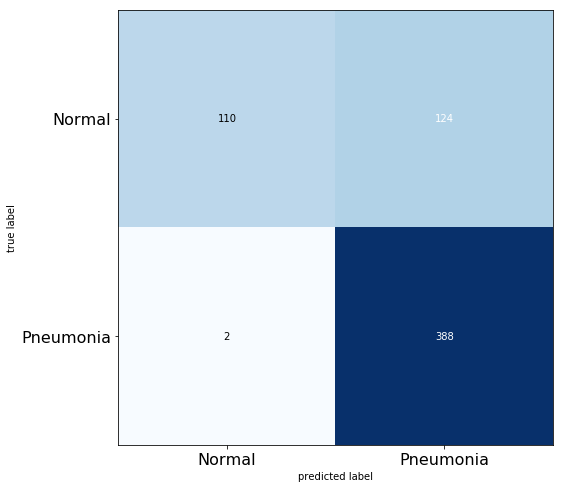

In [0]:
# Get the confusion matrix
cm  = confusion_matrix(labels, pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [0]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall/Sensitivity of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))


Recall/Sensitivity of the model is 0.99
Precision of the model is 0.76


### AUC-ROC Curve
 It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. For our case, Higher the AUC, better the model is at distinguishing between patients with disease and no disease. For an ideal model, the AUC is close to 1 and for a model as good as random guessing it's 0.5

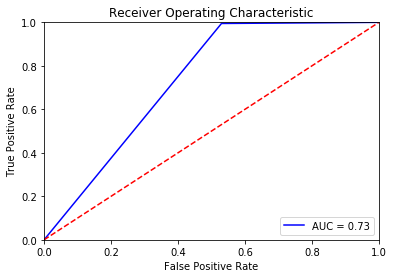

In [0]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(labels, pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Class Activation Maps
Here, I have used Gradient-weighted Class Activation Maps.It uses the gradients of any target concept (say logits for ‘cat’), flowing into the
final convolutional layer to produce a coarse localization
map highlighting the important regions in the image for predicting the concept.

So, to explain in simple terms, we simply take the final convolutional feature map and then we weigh every channel in that feature with the gradient of the class with respect to the channel. It’s just nothing but how intensely the input image activates different channels by how important each channel is with regard to the class. The best part is it doesn’t require any re-training or change in the existing architecture unlike CAM where a Global Average Pooling layer is needed to generate activations.
![](https://pbs.twimg.com/media/DTRSmgHXcAEYask.jpg)

In [0]:

from skimage import data, color, io, img_as_float
def get_heatmap(processed_image, class_idx):
    # we want the activations for the predicted label
    class_output = vgg_conv.output[:, class_idx]
    
    # choose the last conv layer in your model
    last_conv_layer = vgg_conv.get_layer('block5_conv3')
    
    # get the gradients wrt to the last conv layer
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    
   # we pool the gradients over all the axes leaving out the channel dimension
    pooled_grads = K.mean(grads, axis=(0,1,2))
    
    # Define a function that generates the values for the output and gradients
    iterate = K.function([vgg_conv.input], [pooled_grads, last_conv_layer.output[0]])
    
    # get the values
    grads_values, conv_ouput_values = iterate([processed_image])
    
    # iterate over each feature map in your conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    for i in range(512): # we have 512 features in our last conv layer
        conv_ouput_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_ouput_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    return heatmap

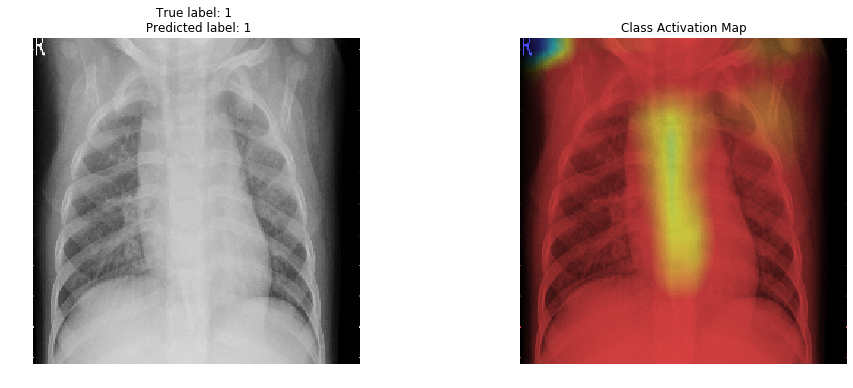

In [0]:

# select the sample and read the corresponding image and label
sample_image = cv2.imread('../input/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg')
# pre-process the image
sample_image = cv2.resize(sample_image, (224,224))
if sample_image.shape[2] ==1:
            sample_image = np.dstack([sample_image, sample_image, sample_image])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = sample_image.astype(np.float32)/255.
sample_label = 1
    
    
sample_image_processed = np.expand_dims(sample_image, axis=0)#since we pass only one image,we expand dim to include
                                                             #batch size 1
    
# get the label predicted by our original model
pred_label = np.argmax(vgg_conv.predict(sample_image_processed), axis=-1)[0]
    
    
# get the heatmap for class activation map(CAM)
heatmap = get_heatmap(sample_image_processed, pred_label)
heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
heatmap = heatmap *255
heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#superimpose the heatmap on the image    

sample_image_hsv = color.rgb2hsv(sample_image)
heatmap = color.rgb2hsv(heatmap)

alpha=0.7
sample_image_hsv[..., 0] = heatmap[..., 0]
sample_image_hsv[..., 1] = heatmap[..., 1] * alpha

img_masked = color.hsv2rgb(sample_image_hsv)

f,ax = plt.subplots(1,2, figsize=(16,6))
ax[0].imshow(sample_image)
ax[0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
ax[0].axis('off')
    
ax[1].imshow(img_masked)
ax[1].set_title("Class Activation Map")
ax[1].axis('off')

plt.show()

CAM proves to be useful in interpreting the model, to know whether the CNN percieves x-ray images as radiologists do, or whether it learns unuseful features to make predictions.


